## NYC Taxi Data Challenge
##### Author: Okwudili Ezeme

### ML Problem
- Forecast the number of pickups by hour for the next 12 hours
- Recommend a pickup spot based on coordinates and time of day.

### Performance Metrics
- MAPE
- MSE

### Table of Content
1. Exploratory Data Analysis
2. Data Visualization and Cleaning
3. Creating Regions and Time Binning
4. Feature Engineering
5. Modeling and Regression

#### Data
We are using the February 2016 Green Taxi data which can be downloaded from [NYC Taxis data website](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [83]:
# Import libraries
import os
import sys
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from gpxpy.geo import haversine_distance
import tensorflow as tf
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from datetime import datetime
import math
import xgboost as xgb
#from gpxpy.geo import haversine_distance
import time
sns.set(style='darkgrid',context='poster')

### 1. Exploratory Data Analysis

Firstly, we need to understand the data which we are working with. Therefore, I am starting off by checking the dimesnion of the data, data types, missingness, etc. 

In [2]:
# we start off by loading the data
tripdata_df = pd.read_csv("../data/tripdata.csv") 

##### Question 1: Report the number of Rows and colums

In [3]:
print(f'>>> Number of rows: {tripdata_df.shape[0]}\n>>> Number of columns: {tripdata_df.shape[1]}')

>>> Number of rows: 1510722
>>> Number of columns: 21


In [4]:
# let take a look at a sample data
tripdata_df.head()

VendorID lpep_pickup_datetime Lpep_dropoff_datetime Store_and_fwd_flag  \
0         2  2016-02-01 00:00:01   2016-02-01 00:10:06                  N   
1         2  2016-02-01 00:01:33   2016-02-01 00:20:13                  N   
2         2  2016-02-01 00:03:46   2016-02-01 00:21:04                  N   
3         2  2016-02-01 00:00:05   2016-02-01 00:06:48                  N   
4         2  2016-02-01 00:06:20   2016-02-01 00:08:47                  N   

   RateCodeID  Pickup_longitude  Pickup_latitude  Dropoff_longitude  \
0           1        -73.939018        40.805214         -73.972534   
1           1        -73.891495        40.746651         -73.890877   
2           1        -73.983780        40.676132         -73.956978   
3           1        -73.807518        40.700375         -73.831657   
4           1        -73.903961        40.744934         -73.900009   

   Dropoff_latitude  Passenger_count  ...  Fare_amount  Extra  MTA_tax  \
0         40.785885                1  ...         10.5    0.5      0.5   
1         40.743896                1  ...         13.0    0.5      0.5   
2         40.718327                1  ...         17.5    0.5      0.5   
3         40.705978                1  ...          8.0    0.5      0.5   
4         40.733601                5  ...          5.0    0.5      0.5   

   Tip_amount  Tolls_amount  Ehail_fee  improvement_surcharge  Total_amount  \
0        0.00           0.0        NaN                    0.3         11.80   
1        0.00           0.0        NaN                    0.3         14.30   
2        3.76           0.0        NaN                    0.3         22.56   
3        0.00           0.0        NaN                    0.3          9.30   
4        0.00           0.0        NaN                    0.3          6.30   

   Payment_type  Trip_type   
0             2         1.0  
1             2         1.0  
2             1         1.0  
3             2         1.0  
4             2         1.0  

[5 rows x 21 columns]

It is a good idea to know the data types of the features we have in the data. From the table above, the features seem to be a mixture of categorical and numerical data. The Ehail_fee seems to have lots of missing values too but we will get to that in a jiffy.

In [5]:
tripdata_df.dtypes

VendorID                   int64
lpep_pickup_datetime      object
Lpep_dropoff_datetime     object
Store_and_fwd_flag        object
RateCodeID                 int64
Pickup_longitude         float64
Pickup_latitude          float64
Dropoff_longitude        float64
Dropoff_latitude         float64
Passenger_count            int64
Trip_distance            float64
Fare_amount              float64
Extra                    float64
MTA_tax                  float64
Tip_amount               float64
Tolls_amount             float64
Ehail_fee                float64
improvement_surcharge    float64
Total_amount             float64
Payment_type               int64
Trip_type                float64
dtype: object

##### Detecting and Handling Missing values

Before I proceed further, it is important to find out which features have missing values so that we will devise means of handing them.

In [6]:
# get the total of missing values per colum and publish
missing_val_col = tripdata_df.isna().sum()
print(f'>>> Missing data by column details:\n{missing_val_col[missing_val_col > 0]}')

>>> Missing data by column details:
Ehail_fee     1510722
Trip_type           2
dtype: int64


Luckily, only two features **Ehail_fee** and **Trip_type** have missing values. When I look at the data dictionary for the green taxi, there was no feature named **Ehail_fee**, suggesting that it may be an upcoming feature. And since it practically has no valid input, we will be dropping that column. Also, the **Trip_type** feature has only two missing values, therefore, we can conveniently drop those two rows.

In [7]:
# drop the colum first before dropping the 2 rows of trip type
tripdata_df.dropna(axis=1,how='all',inplace=True)
tripdata_df.dropna(axis=0,inplace=True)
print(f'>>> New shape: {tripdata_df.shape}')

>>> New shape: (1510720, 20)


### 2. Data Visualization and Cleaning

To avoid my decisions being influenced by theory alone, let us visualize some of the features and confirm whether our theorems correlate with insights from the data. First, we check some of the coordinates to see if they are valid.

In [8]:
def plot_map(location, dataframe, action):
    """
    Given a default location and dataframe, it plots the data on the map
    Params:
        - location: defualt location of the city of interest
        - dataframe: dataframe that has latitude and longitude
        - action: defines whether we are picking up or dropping off
    Returns:
        - a map object
    """
    lat = f'{action}_latitude'
    lon = f'{action}_longitude'
    pickup_map = folium.Map(location=location)
    for idx, data in dataframe.iterrows():
        if data["Pickup_latitude"] != 0: # we dont want to land in Uk or Ghana
            folium.Marker(location=[data[lat],data[lon]]).add_to(pickup_map)
    return pickup_map

In [9]:
# let us view a snapshot of the the pickup to check for data anomaly
location = [40.730610, -73.935242]
sample_data = tripdata_df.sample(30000)
action = 'Pickup'
# let us view a snapshot of the the pickup to check for data anomaly
pickup_map = plot_map(location,sample_data,action)
pickup_map

From the pickup plot, we see pickups in nearby state of New Jersey. What this suggests is that even when we cant find missing values, our data is far from being clean. Therefore, we will take care of this by concentrating only on data from New York city using the bounding coordinates (**(40.5774, -74.15)** and **(40.9176,-73.7004)**) for the latitude and longitude respectively as they are the bounding coordinates of New york City. 

##### Pickup  and Dropoff coordinates cleaning

In [10]:
pickups_outisde_NYC = tripdata_df.index[(tripdata_df.Pickup_latitude < 40.5774) |
                                        (tripdata_df.Pickup_latitude > 40.9176) 
                                        | (tripdata_df.Pickup_longitude <  -74.15) 
                                        | (tripdata_df.Pickup_longitude > -73.7004)].tolist()

dropoffs_outside_NYC = tripdata_df.index[(tripdata_df.Dropoff_latitude < 40.5774)| 
                                         (tripdata_df.Dropoff_latitude > 40.9176)
                                         | (tripdata_df.Dropoff_longitude <  -74.15) 
                                         | (tripdata_df.Dropoff_longitude > -73.7004)].tolist()
#combine the two data using set
print(f'>>> Num. of invalid pickups: {len(pickups_outisde_NYC)}\n>>> Num. of invalid droppoffs: {len(dropoffs_outside_NYC)}')
outside_NYC = set(pickups_outisde_NYC).union(set(dropoffs_outside_NYC))
print(f'>>> Length of rows to drop: {len(outside_NYC)}')

print(f'>>> Sample index to be dropped: {list(outside_NYC)[:5]}')

>>> Num. of invalid pickups: 4936
>>> Num. of invalid droppoffs: 6634
>>> Length of rows to drop: 9396
>>> Sample index to be dropped: [360448, 688128, 1441796, 884742, 917513]


Since we have identified trips that did not originate or end in New York City, we will proceed to drop those trips from our data because our tasks centers on trips in NYC.

In [11]:
# we drop and check out our new shape.
new_tripdata_df = tripdata_df.drop(index=outside_NYC)
new_tripdata_df.shape

(1501324, 20)

##### Handling the categorical data

Since the **Store_and_fwd_flag** is made up of Yes or No. We convert it to categorical column and place them with the cat codes which are numerical. First, we convert the column to *category* type and extract the codes.

In [12]:
new_tripdata_df.Store_and_fwd_flag = pd.Categorical(new_tripdata_df.Store_and_fwd_flag).codes
new_tripdata_df.head() # confirm that we have converted the category to numeric value

VendorID lpep_pickup_datetime Lpep_dropoff_datetime  Store_and_fwd_flag  \
0         2  2016-02-01 00:00:01   2016-02-01 00:10:06                   0   
1         2  2016-02-01 00:01:33   2016-02-01 00:20:13                   0   
2         2  2016-02-01 00:03:46   2016-02-01 00:21:04                   0   
3         2  2016-02-01 00:00:05   2016-02-01 00:06:48                   0   
4         2  2016-02-01 00:06:20   2016-02-01 00:08:47                   0   

   RateCodeID  Pickup_longitude  Pickup_latitude  Dropoff_longitude  \
0           1        -73.939018        40.805214         -73.972534   
1           1        -73.891495        40.746651         -73.890877   
2           1        -73.983780        40.676132         -73.956978   
3           1        -73.807518        40.700375         -73.831657   
4           1        -73.903961        40.744934         -73.900009   

   Dropoff_latitude  Passenger_count  Trip_distance  Fare_amount  Extra  \
0         40.785885                1           2.86         10.5    0.5   
1         40.743896                1           3.35         13.0    0.5   
2         40.718327                1           4.70         17.5    0.5   
3         40.705978                1           2.11          8.0    0.5   
4         40.733601                5           0.98          5.0    0.5   

   MTA_tax  Tip_amount  Tolls_amount  improvement_surcharge  Total_amount  \
0      0.5        0.00           0.0                    0.3         11.80   
1      0.5        0.00           0.0                    0.3         14.30   
2      0.5        3.76           0.0                    0.3         22.56   
3      0.5        0.00           0.0                    0.3          9.30   
4      0.5        0.00           0.0                    0.3          6.30   

   Payment_type  Trip_type   
0             2         1.0  
1             2         1.0  
2             1         1.0  
3             2         1.0  
4             2         1.0

##### Handling the DateTime Variables

From the features, the **lpep_pickup_datetime** and **Lpep_dropoff_datetime** are datetime variables that need further manipulation to be usable in the sense of our task. Specifically, we want to extract the *hour, day of the week*, and *week of the year*. These features are necessary to capture any seasonality in the data.

In [13]:
pickup_time = pd.to_datetime(new_tripdata_df['lpep_pickup_datetime'])
dropoff_time = pd.to_datetime(new_tripdata_df['Lpep_dropoff_datetime'])

# extract the pickup hours, days and weeks of the year and add them to data as new features
new_tripdata_df['pickup_hour'] = pickup_time.apply(lambda x: x.hour)
new_tripdata_df['pickup_day'] = pickup_time.apply(lambda x: x.dayofweek)
new_tripdata_df['pickup_week'] = pickup_time.apply(lambda x : x.week)

# dropoff features
new_tripdata_df['dropoff_hour'] = dropoff_time.apply(lambda x: x.hour)
new_tripdata_df['dropoff_day'] = dropoff_time.apply(lambda x: x.dayofweek)
new_tripdata_df['dropoff_week'] = dropoff_time.apply(lambda x : x.week)

print(new_tripdata_df.shape)
new_tripdata_df.head()

(1501324, 26)


VendorID lpep_pickup_datetime Lpep_dropoff_datetime  Store_and_fwd_flag  \
0         2  2016-02-01 00:00:01   2016-02-01 00:10:06                   0   
1         2  2016-02-01 00:01:33   2016-02-01 00:20:13                   0   
2         2  2016-02-01 00:03:46   2016-02-01 00:21:04                   0   
3         2  2016-02-01 00:00:05   2016-02-01 00:06:48                   0   
4         2  2016-02-01 00:06:20   2016-02-01 00:08:47                   0   

   RateCodeID  Pickup_longitude  Pickup_latitude  Dropoff_longitude  \
0           1        -73.939018        40.805214         -73.972534   
1           1        -73.891495        40.746651         -73.890877   
2           1        -73.983780        40.676132         -73.956978   
3           1        -73.807518        40.700375         -73.831657   
4           1        -73.903961        40.744934         -73.900009   

   Dropoff_latitude  Passenger_count  ...  improvement_surcharge  \
0         40.785885                1  ...                    0.3   
1         40.743896                1  ...                    0.3   
2         40.718327                1  ...                    0.3   
3         40.705978                1  ...                    0.3   
4         40.733601                5  ...                    0.3   

   Total_amount  Payment_type  Trip_type   pickup_hour  pickup_day  \
0         11.80             2         1.0            0           0   
1         14.30             2         1.0            0           0   
2         22.56             1         1.0            0           0   
3          9.30             2         1.0            0           0   
4          6.30             2         1.0            0           0   

   pickup_week  dropoff_hour  dropoff_day  dropoff_week  
0            5             0            0             5  
1            5             0            0             5  
2            5             0            0             5  
3            5             0            0             5  
4            5             0            0             5  

[5 rows x 26 columns]

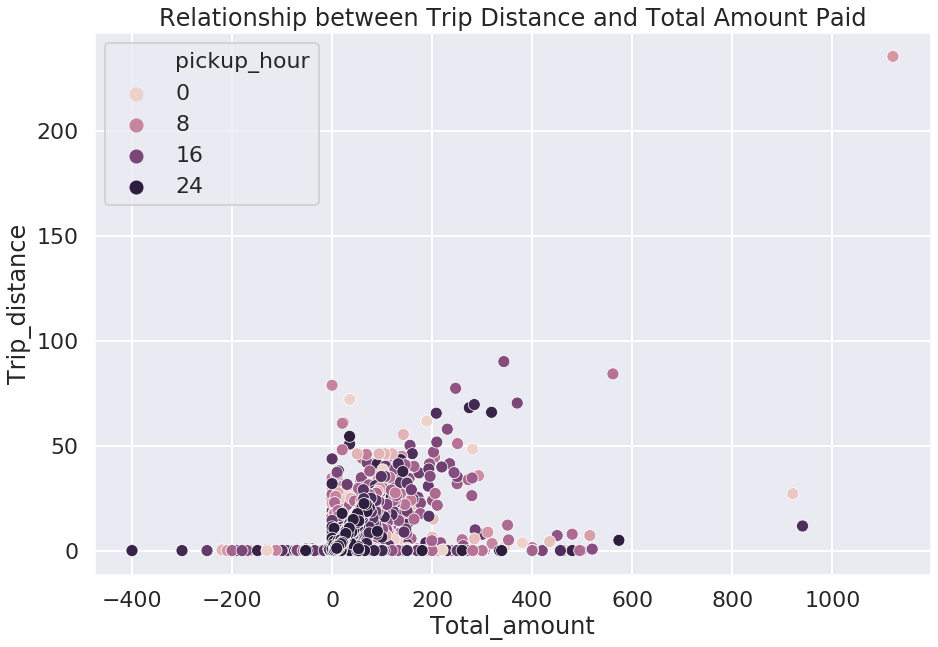

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x='Total_amount',y="Trip_distance",hue="pickup_hour",data=new_tripdata_df, ax=ax)
plt.title("Relationship between Trip Distance and Total Amount Paid")
plt.show()

Curiously, there are negative trip amounts up to -400 USD? Could it be there is a negative charge when the car broke down on a trip or maybe there was incidents between the driver and the passenger that made the passenger not to pay the driver? On the positive side, there exists correlation between the two parameters on the positive values of the total amount paid. The trip distance values are also suspect. Is it possible for somebody to drive up to 200 miles in NYC? Therefore, we will clean these features.

##### Cleaning the Total Amount Feature

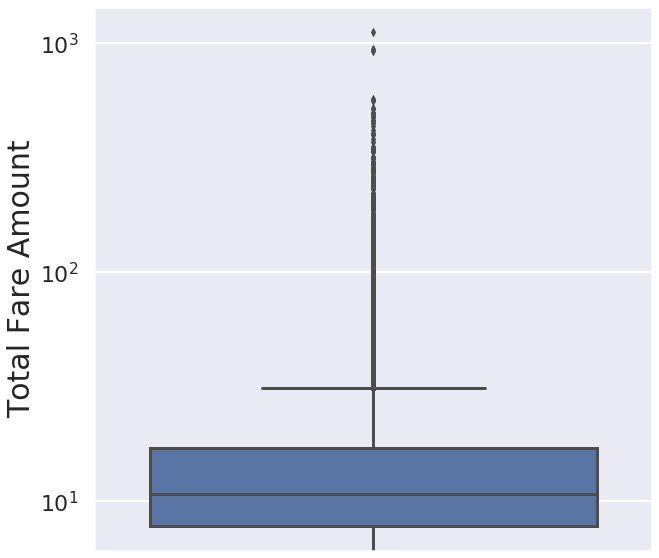

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot("Total_amount", data=new_tripdata_df,orient='v', ax=ax)
ax.set_yscale("log")
plt.ylabel("Total Fare Amount", fontsize=30)
plt.show()

So, the negative trip fare amount has become clear. Let us work with the quantile to get to the root of the matter.

In [16]:
# get the percentile and examine the values.
quant_total_amount = new_tripdata_df.Total_amount.quantile(np.round(np.arange(0.0,1.01,.01),2))
quant_intervals = np.round(np.arange(0.0,1.01,.01),2)
for idx in quant_intervals:
    print(f'>>> {int(idx*100)} percentile value: {quant_total_amount[idx]}')

>>> 0 percentile value: -400.0
>>> 1 percentile value: 3.8
>>> 2 percentile value: 4.8
>>> 3 percentile value: 4.8
>>> 4 percentile value: 5.3
>>> 5 percentile value: 5.3
>>> 6 percentile value: 5.76
>>> 7 percentile value: 5.8
>>> 8 percentile value: 5.8
>>> 9 percentile value: 5.8
>>> 10 percentile value: 6.3
>>> 11 percentile value: 6.3
>>> 12 percentile value: 6.299999999999999
>>> 13 percentile value: 6.36
>>> 14 percentile value: 6.8
>>> 15 percentile value: 6.8
>>> 16 percentile value: 6.8
>>> 17 percentile value: 6.8
>>> 18 percentile value: 6.96
>>> 19 percentile value: 7.300000000000001
>>> 20 percentile value: 7.300000000000001
>>> 21 percentile value: 7.3
>>> 22 percentile value: 7.5
>>> 23 percentile value: 7.56
>>> 24 percentile value: 7.8
>>> 25 percentile value: 7.8
>>> 26 percentile value: 7.8
>>> 27 percentile value: 8.0
>>> 28 percentile value: 8.16
>>> 28 percentile value: 8.3
>>> 30 percentile value: 8.3
>>> 31 percentile value: 8.3
>>> 32 percentile value: 8.75
>>

Interesting! *0th percentile* is -400 while *100th percentile* is 1121.16 USD. While the 100th percentile amount is not too outrageous for NYC residents. Lets play one more card to see if that data is an anomaly. Lets examine the 99th to 100th percentile.

In [17]:
quant_total_amount = new_tripdata_df.Total_amount.quantile(np.round(np.arange(0.991,1.001,0.001),3))
quant_intervals = np.round(np.arange(0.991,1.001,0.001),3)
for idx in quant_intervals:
    print(f'>>> {idx*100} percentile value: {quant_total_amount[idx]}')

>>> 99.1 percentile value: 52.8
>>> 99.2 percentile value: 54.36
>>> 99.3 percentile value: 56.29
>>> 99.4 percentile value: 58.34
>>> 99.5 percentile value: 60.14999999999999
>>> 99.6 percentile value: 63.34
>>> 99.7 percentile value: 67.09
>>> 99.8 percentile value: 70.56
>>> 99.9 percentile value: 80.0
>>> 100.0 percentile value: 1121.16


As can be seen from the cell above, the 99.9th percentile is 80 dollars while the 100th percentile is 1121.16 which suggests an anomalous data. Therefore, we will filter negative trip fare amount and cap the fare at 80 dollars.

In [18]:
new_tripdata_df = new_tripdata_df[(new_tripdata_df.Total_amount > 0)& (new_tripdata_df.Total_amount <= 80)]
new_tripdata_df.shape

(1493366, 26)

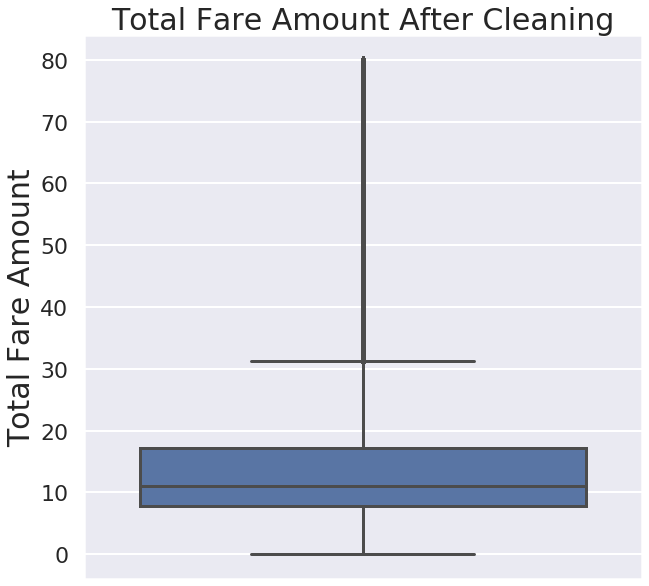

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot("Total_amount", data=new_tripdata_df,orient='v', ax=ax)
#ax.set_yscale("log")
plt.ylabel("Total Fare Amount", fontsize=30)
plt.title("Total Fare Amount After Cleaning", fontsize=30)
plt.show()

##### Cleaning the Trip Distance Variable

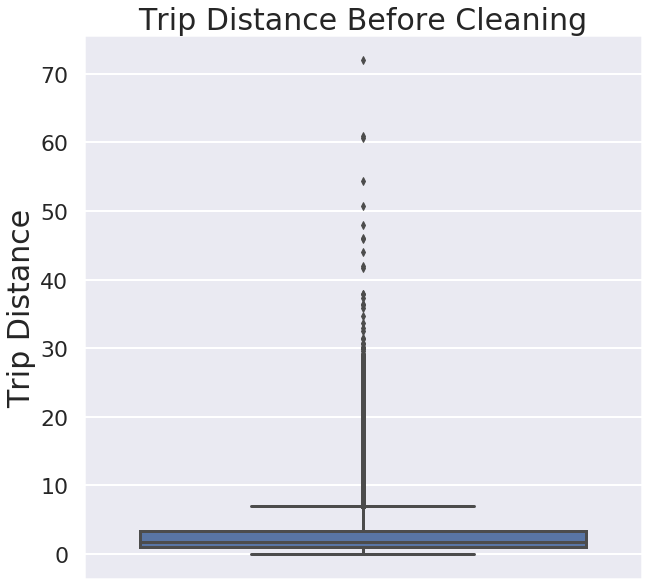

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot("Trip_distance", data=new_tripdata_df,orient='v', ax=ax)
#ax.set_yscale("log")
plt.ylabel("Trip Distance", fontsize=30)
plt.title("Trip Distance Before Cleaning", fontsize=30)
plt.show()

Again, let us examine the percentile to see if the 200+ miles distance in NYC makes any sense.

In [21]:
# get the percentile and examine the values.
quant_trip_distance = new_tripdata_df.Trip_distance.quantile(np.round(np.arange(0.0,1.01,.01),2))
quant_intervals = np.round(np.arange(0.0,1.01,.01),2)
for idx in quant_intervals:
    print(f'>>> {int(idx*100)} percentile value: {quant_trip_distance[idx]}')

>>> 0 percentile value: 0.0
>>> 1 percentile value: 0.0
>>> 2 percentile value: 0.24
>>> 3 percentile value: 0.36
>>> 4 percentile value: 0.41
>>> 5 percentile value: 0.47
>>> 6 percentile value: 0.5
>>> 7 percentile value: 0.54
>>> 8 percentile value: 0.58
>>> 9 percentile value: 0.6
>>> 10 percentile value: 0.63
>>> 11 percentile value: 0.6700000000000002
>>> 12 percentile value: 0.7
>>> 13 percentile value: 0.71
>>> 14 percentile value: 0.74
>>> 15 percentile value: 0.77
>>> 16 percentile value: 0.8
>>> 17 percentile value: 0.81
>>> 18 percentile value: 0.8399999999999999
>>> 19 percentile value: 0.87
>>> 20 percentile value: 0.9
>>> 21 percentile value: 0.9
>>> 22 percentile value: 0.9300000000000002
>>> 23 percentile value: 0.96
>>> 24 percentile value: 0.99
>>> 25 percentile value: 1.0
>>> 26 percentile value: 1.03
>>> 27 percentile value: 1.06
>>> 28 percentile value: 1.09
>>> 28 percentile value: 1.1
>>> 30 percentile value: 1.13
>>> 31 percentile value: 1.16
>>> 32 percentile 

Great! It appears the cleaning on the total amount has taken most of the erroneous data out but we still need to examine the last 10 percentile between 99 and 100.

In [22]:
quant_trip_distance = new_tripdata_df.Trip_distance.quantile(np.round(np.arange(0.991,1.001,0.001),3))
quant_intervals = np.round(np.arange(0.991,1.001,0.001),3)
for idx in quant_intervals:
    print(f'>>> {idx*100} percentile value: {quant_trip_distance[idx]}')

>>> 99.1 percentile value: 13.620000000000001
>>> 99.2 percentile value: 14.08
>>> 99.3 percentile value: 14.59
>>> 99.4 percentile value: 15.1
>>> 99.5 percentile value: 15.63
>>> 99.6 percentile value: 16.52
>>> 99.7 percentile value: 17.54
>>> 99.8 percentile value: 18.4
>>> 99.9 percentile value: 19.67
>>> 100.0 percentile value: 72.02


Just like the trip amount, 99.9 percentile is 19.67 miles while 100th percentile jumps to 72.02 miles which appears to be too high. Therefore, we will filter out these values that are greater than 20 miles.

In [23]:
new_tripdata_df = new_tripdata_df[(new_tripdata_df.Trip_distance > 0)& (new_tripdata_df.Trip_distance < 20)]
new_tripdata_df.shape

(1476603, 26)

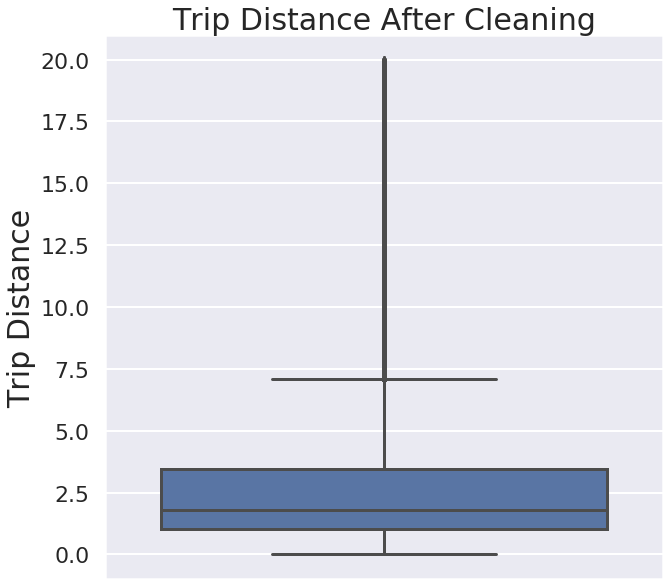

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot("Trip_distance", data=new_tripdata_df,orient='v', ax=ax)
#ax.set_yscale("log")
plt.ylabel("Trip Distance", fontsize=30)
plt.title("Trip Distance After Cleaning", fontsize=30)
plt.show()

##### Adding Pickup Time and Trip Duration features

Another potential source of erroneous data is the trip duration. We also need to add the exact time a pickup is requested so that we can use it in the machine learning phase.

In [25]:
def time_in_gmt(datetime_arg):
    """
    Given a datetime parameter, returns time in seconds with reference to GMT
    params:
        - datetime: a datetime parameter
    Returns:
        - time: time in seconds with reference to GMT
    """
    datetime_format = datetime.strptime(datetime_arg,"%Y-%m-%d %H:%M:%S")
    time_tuple = datetime_format.timetuple()
    return time.mktime(time_tuple)+ 18000 # compensate for time difference

def add_new_features(trip_dataframe):
    """
    Add the trip duration and pickup time here.
    """
    duration_df = trip_dataframe[['lpep_pickup_datetime','Lpep_dropoff_datetime']].copy()
    pickup_time = [time_in_gmt(val) for val in duration_df['lpep_pickup_datetime'].values]
    dropoff_time = [time_in_gmt(val) for val in duration_df['Lpep_dropoff_datetime'].values]
    # compute trip duration in minutes
    trip_duration = (np.array(dropoff_time) - np.array(pickup_time))/float(60)
    
    trip_dataframe["pickup_time"] = pickup_time
    trip_dataframe["trip_duration"] = trip_duration
    return trip_dataframe

clean_tripdata_df = add_new_features(new_tripdata_df)

##### Cleaning Trip Durations

In NYC, the regulations allow a maximum of 12 hours in a 24 hour duration. So, we will examine to see if there is any deviation from this regulation.

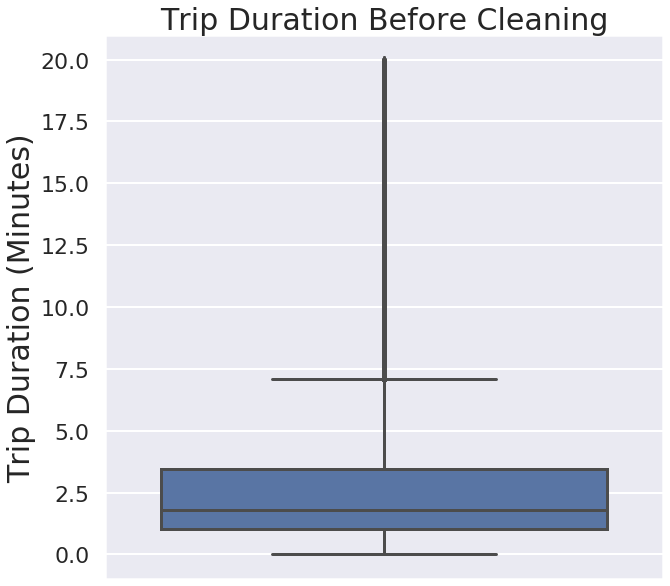

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot("Trip_distance", data=clean_tripdata_df,orient='v', ax=ax)
#ax.set_yscale("log")
plt.ylabel("Trip Duration (Minutes)", fontsize=30)
plt.title("Trip Duration Before Cleaning", fontsize=30)
plt.show()

In [27]:
# let us examine the values using the percentile principle
quant_trip_duration = clean_tripdata_df.trip_duration.quantile(np.round(np.arange(0.0,1.01,.01),2))
quant_intervals = np.round(np.arange(0.0,1.01,.01),2)
for idx in quant_intervals:
    print(f'>>> {int(idx*100)} percentile value: {quant_trip_duration[idx]}')

>>> 0 percentile value: 0.0
>>> 1 percentile value: 1.3
>>> 2 percentile value: 1.9
>>> 3 percentile value: 2.2666666666666666
>>> 4 percentile value: 2.55
>>> 5 percentile value: 2.783333333333333
>>> 6 percentile value: 3.0
>>> 7 percentile value: 3.1833333333333336
>>> 8 percentile value: 3.3666666666666667
>>> 9 percentile value: 3.55
>>> 10 percentile value: 3.716666666666667
>>> 11 percentile value: 3.8666666666666667
>>> 12 percentile value: 4.016666666666667
>>> 13 percentile value: 4.166666666666667
>>> 14 percentile value: 4.316666666666666
>>> 15 percentile value: 4.466666666666667
>>> 16 percentile value: 4.616666666666666
>>> 17 percentile value: 4.75
>>> 18 percentile value: 4.883333333333334
>>> 19 percentile value: 5.033333333333333
>>> 20 percentile value: 5.166666666666667
>>> 21 percentile value: 5.3
>>> 22 percentile value: 5.45
>>> 23 percentile value: 5.583333333333333
>>> 24 percentile value: 5.716666666666667
>>> 25 percentile value: 5.866666666666666
>>> 26 per

In [28]:
# let us examine the last 10 percentiles from 99.1 to 100
quant_trip_duration = clean_tripdata_df.trip_duration.quantile(np.round(np.arange(0.991,1.001,.001),3))
quant_intervals = np.round(np.arange(0.991,1.001,.001),3)
for idx in quant_intervals:
    print(f'>>> {idx*100} percentile value: {quant_trip_duration[idx]}')

>>> 99.1 percentile value: 68.75
>>> 99.2 percentile value: 83.3227999999964
>>> 99.3 percentile value: 329.8834000000187
>>> 99.4 percentile value: 836.8994666668276
>>> 99.5 percentile value: 1385.1159999999993
>>> 99.6 percentile value: 1409.45
>>> 99.7 percentile value: 1420.55
>>> 99.8 percentile value: 1428.0166666666667
>>> 99.9 percentile value: 1433.7666666666667
>>> 100.0 percentile value: 1439.95


Wow! Lots of unrealistic samples exist here. The 99.3th percentile is **5.498 hours** and why it is high, it may not be completely unrealistic in NYC if someone charted a taxi for some hours. Therefore, I will cap the value at this percentile as all others are more than 12 hours limit imposed by the regulation. 

In [29]:
clean_tripdata_df = clean_tripdata_df[(clean_tripdata_df.trip_duration > 0)& (clean_tripdata_df.trip_duration < 330)]
clean_tripdata_df.shape

(1466170, 28)

In [30]:
print(f'>>> After data cleaning, {tripdata_df.shape[0]-clean_tripdata_df.shape[0]} samples were removed')

>>> After data cleaning, 44550 samples were removed


##### Question 2: Visualize trip Distance by time of the day, any observations?

Now that we have the hours of the day, we can examine the relationship between trip distance by the pickup hours of the day.

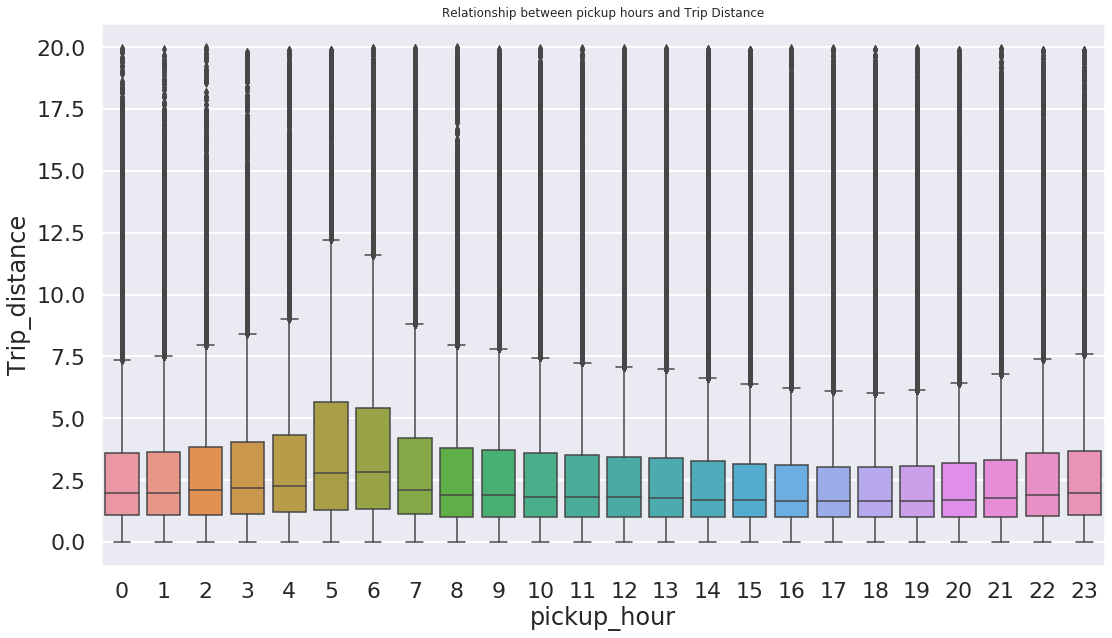

In [31]:
fig, ax = plt.subplots(figsize=(18,10))
sns.set(style="darkgrid")
sns.boxplot(x='pickup_hour',y="Trip_distance",
                data=clean_tripdata_df, ax=ax)
#ax.set_yscale("log")
plt.title("Relationship between pickup hours and Trip Distance")
plt.show()

##### Answer to Question 2

The following are my observations:
- The H-Spread of the box plots of the early morning (4-7 a.m.) trips have higher variability. This could be because those that live in the outskirts of NYC depart very early for work to beat the traffic and the higher distances which they have to commute to work increases the variability of the trip distances during these hours. 
- On the contrary, between 7-9 a.m., those that live in the city make their short commute to work, and as work resumes, long trip distances reduce and taperss off around 6 p.m. because only those that have short commute favor taxi at the evening rush hour.
- The bubbling night life of NYC also reflects on the data as the medium and long distance trips resume again from 10 p.m. as people make their way to and from the different attractions in NYC.
- Skewed data: Throughout the 24 hours period, the trip distance data is skewed to the right with the right having high variability. 
- Outliers: All the hours have outliers in the long distance range showing that long distance trip are not a frequent occurence.
- Stationarity: Despite its skewed nature and the presence of outliers, the trip distance maintains a predictable periodic pattern suggesting that the data might be stationary
- Surprisingly, the variability during the afternoon/evening rush hour does not match the early morning rush hour. This suggests that taxi might be a transport choice when going to work early morning because the traffic is not heavy but after work, people might prefer other modes like train which does not suffer traffic delays.

### 3. Region Segmentation and time Binning

Since we will be making forecasts per hour, I need to transform the data into time bin of pikcups per hours. Also, the pickups uses latitude and longitude, therefore, I need to create regions of pickups spots. The following steps are implemented:

- Aggregation by hour
- Creation of pickup regions

Since ordinary distance metric is not suitable on geo-spatial data, I will be using the **Haversine distance** to compute the point neighborhood in the geospatial data. For creation of the pickup regions, *K-Means* and *DBSCAN* are options but since K-Means reduces variance and not geodetic distance, DBSCAN would have been the best option but it has lots memory issues with large dataset. Therefore, I will create a workaround using K-Means clustering and Haversine distance.  

In [54]:
def create_pickup_clusters(num_clusters, coords):
    """
    Creates clusters for our pickup regions
    """
    clusters = KMeans(n_clusters=num_clusters, random_state=10).fit(coords)
    cluster_centers = clusters.cluster_centers_
    len_clusters = len(cluster_centers)
    return cluster_centers, len_clusters

def optimize_clusters(centers,num_of_clusters):
    """
    Iteratively determine the optimum number of clusters that meet the minimum distance between clsuters
    We want a balance between inter-cluster distance and number of clusters. 
    We limit the minimum distance between clusters to 0.3 miles so that people can walk it. 
    """
    valid_points = 0
    invalid_points = 0
    distance_less = []
    distance_more = []
    min_dist = 120000
    for x in np.arange(num_of_clusters):
        valid_points = 0
        invalid_points = 0
        for y in np.arange(num_of_clusters):
            if x != y: # dont compare against yourself
                h_distance = haversine_distance(latitude_1=centers[x][0],longitude_1=centers[x][1],
                                               latitude_2=centers[y][0],longitude_2=centers[y][1])
                # convert from kilometers to miles
                h_distance = h_distance/float(1609)
                min_dist = min(min_dist, h_distance)
                if h_distance < 2:
                    valid_points += 1
                else:
                    invalid_points += 1
        distance_less.append(valid_points)
        distance_more.append(invalid_points)
    print(f'>>> For a total pickup cluster of: {num_of_clusters}')
    print(f'>>> Mean clusters within region for inter-cluster distance < 2 miles is : {np.ceil(sum(distance_less)/len(distance_less))}')
    print(f'>>> Mean clusters within region for inter-cluster distance > 2 miles is : {np.ceil(sum(distance_more)/len(distance_more))}')
    print(f'>>> Minimum distance between any two clusters is: {min_dist:.3f} miles')
   


In [55]:
 # compute the clusters
coordinates = clean_tripdata_df[['Pickup_latitude','Pickup_longitude']].values
start_time = time.time()

# try different cluster sizes
for num_clusters in np.arange(10,120,10):
    centers, len_clusters = create_pickup_clusters(num_clusters,coordinates)
    optimize_clusters(centers,len_clusters)
compute_duration = time.time() - start_time()
print(f'>>> Compute time: {compute_duration:.4f}')

>>> For a total pickup cluster of: 10
>>> Mean clusters within region for inter-cluster distance < 2 miles is : 0.0
>>> Mean clusters within region for inter-cluster distance > 2 miles is : 9.0
>>> Minimum distance between any two clusters is: 2.167 miles
>>> For a total pickup cluster of: 20
>>> Mean clusters within region for inter-cluster distance < 2 miles is : 2.0
>>> Mean clusters within region for inter-cluster distance > 2 miles is : 18.0
>>> Minimum distance between any two clusters is: 1.043 miles
>>> For a total pickup cluster of: 30
>>> Mean clusters within region for inter-cluster distance < 2 miles is : 3.0
>>> Mean clusters within region for inter-cluster distance > 2 miles is : 27.0
>>> Minimum distance between any two clusters is: 0.790 miles
>>> For a total pickup cluster of: 40
>>> Mean clusters within region for inter-cluster distance < 2 miles is : 4.0
>>> Mean clusters within region for inter-cluster distance > 2 miles is : 36.0
>>> Minimum distance between any tw

TypeError: 'float' object is not callable

At 110 clusters, we got minimum inter-cluster distance of 0.186 miles. Since this is less than our requirement of **0.5 miles** between clusters, we will use 105 clusters to add our pickup region feature.

In [57]:
# now that we know the number of clusters to give us minimum of 0.3 miles between pickup regions
# we will compute the clusters
optimal_num_clusters = 105
pickup_cluster = KMeans(n_clusters=optimal_num_clusters, random_state=10).fit(coordinates)

# add pickup region as a feature in the data
clean_tripdata_df['Pickup_region'] = pickup_cluster.predict(clean_tripdata_df[['Pickup_latitude','Pickup_longitude']])

/home/paperspace/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


##### Visualize the Pickup Regions in a map

In [60]:
cluster_centers = pickup_cluster.cluster_centers_
num_clusters = len(set(labels))
region_map = folium.Map(location=[40.9176,-73.7004])

# add each region to the map and tag it with the region coords
for cluster in np.arange(num_clusters):
    folium.Marker([cluster_centers[cluster][0],cluster_centers[cluster][1]],
                  popup=(str(np.round(cluster_centers[cluster][0],2))+", "+
                         str(np.round(cluster_centers[cluster][1],2)))).add_to(region_map)
region_map

In [61]:
clean_tripdata_df.head()

VendorID lpep_pickup_datetime Lpep_dropoff_datetime  Store_and_fwd_flag  \
0         2  2016-02-01 00:00:01   2016-02-01 00:10:06                   0   
1         2  2016-02-01 00:01:33   2016-02-01 00:20:13                   0   
2         2  2016-02-01 00:03:46   2016-02-01 00:21:04                   0   
3         2  2016-02-01 00:00:05   2016-02-01 00:06:48                   0   
4         2  2016-02-01 00:06:20   2016-02-01 00:08:47                   0   

   RateCodeID  Pickup_longitude  Pickup_latitude  Dropoff_longitude  \
0           1        -73.939018        40.805214         -73.972534   
1           1        -73.891495        40.746651         -73.890877   
2           1        -73.983780        40.676132         -73.956978   
3           1        -73.807518        40.700375         -73.831657   
4           1        -73.903961        40.744934         -73.900009   

   Dropoff_latitude  Passenger_count  ...  Trip_type   pickup_hour  \
0         40.785885                1  ...         1.0            0   
1         40.743896                1  ...         1.0            0   
2         40.718327                1  ...         1.0            0   
3         40.705978                1  ...         1.0            0   
4         40.733601                5  ...         1.0            0   

   pickup_day  pickup_week  dropoff_hour  dropoff_day  dropoff_week  \
0           0            5             0            0             5   
1           0            5             0            0             5   
2           0            5             0            0             5   
3           0            5             0            0             5   
4           0            5             0            0             5   

    pickup_time  trip_duration  Pickup_region  
0  1.454321e+09      10.083333             41  
1  1.454321e+09      18.666667             44  
2  1.454321e+09      17.300000             48  
3  1.454321e+09       6.716667             22  
4  1.454321e+09       2.450000             35  

[5 rows x 29 columns]

##### Aggretaion of Trips into Time bins of 1 hour

In [67]:
# from online convertion, we get the epoch time of Feb 01, 2016 at 12 am and subtract
def onehour_bins(tripdata, epoch_time):
    """
    Convert the pickup time to one hour bins. Epoch time is time Feb 01, 2016 at 12 a.m.
    """
    pickup_time = tripdata["pickup_time"].values
    
    # divide by 60*60 to get a one hour window
    bins_hour = [int((val-epoch_time)/3600) for val in pickup_time]
    
    # add the new timebins to our faetures
    tripdata["onehour_bins"] = np.array(bins_hour)
    return tripdata

# get the binned dataframe
epoch_time = 1454284800
clean_tripdata_df = onehour_bins(clean_tripdata_df, epoch_time )

/home/paperspace/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [71]:
clean_tripdata_df.head()

VendorID lpep_pickup_datetime Lpep_dropoff_datetime  Store_and_fwd_flag  \
0         2  2016-02-01 00:00:01   2016-02-01 00:10:06                   0   
1         2  2016-02-01 00:01:33   2016-02-01 00:20:13                   0   
2         2  2016-02-01 00:03:46   2016-02-01 00:21:04                   0   
3         2  2016-02-01 00:00:05   2016-02-01 00:06:48                   0   
4         2  2016-02-01 00:06:20   2016-02-01 00:08:47                   0   

   RateCodeID  Pickup_longitude  Pickup_latitude  Dropoff_longitude  \
0           1        -73.939018        40.805214         -73.972534   
1           1        -73.891495        40.746651         -73.890877   
2           1        -73.983780        40.676132         -73.956978   
3           1        -73.807518        40.700375         -73.831657   
4           1        -73.903961        40.744934         -73.900009   

   Dropoff_latitude  Passenger_count  ...  pickup_hour  pickup_day  \
0         40.785885                1  ...            0           0   
1         40.743896                1  ...            0           0   
2         40.718327                1  ...            0           0   
3         40.705978                1  ...            0           0   
4         40.733601                5  ...            0           0   

   pickup_week  dropoff_hour  dropoff_day  dropoff_week   pickup_time  \
0            5             0            0             5  1.454321e+09   
1            5             0            0             5  1.454321e+09   
2            5             0            0             5  1.454321e+09   
3            5             0            0             5  1.454321e+09   
4            5             0            0             5  1.454321e+09   

   trip_duration  Pickup_region  onehour_bins  
0      10.083333             41            10  
1      18.666667             44            10  
2      17.300000             48            10  
3       6.716667             22            10  
4       2.450000             35            10  

[5 rows x 30 columns]

##### Check and Handle for Time Bins where pickup is zero

In [74]:
def timebins_with_pickup(tripdata):
    """
    Detects all the time bins with valid pickups
    """
    pickup_regions = []
    num_clusters = 105
    for cluster in np.arange(num_clusters):
        idx = tripdata[tripdata["Pickup_region"] == cluster]
        idx_unique = list(set(idx["onehour_bins"]))
        idx_unique.sort()
        pickup_regions.append(idx_unique)
    return pickup_regions

In [75]:
pickedup_bins = timebins_with_pickup(clean_tripdata_df)
total_num_bins = 696 # number of hours in 29 days of February
for cluster in np.arange(optimal_num_clusters):
    print(f"Region: {cluster}\t No pickup bins {total_num_bins-len(pickedup_bins[cluster])} ")

Region: 0	 No pickup bins 5 
Region: 1	 No pickup bins 0 
Region: 2	 No pickup bins 11 
Region: 3	 No pickup bins 1 
Region: 4	 No pickup bins 0 
Region: 5	 No pickup bins 1 
Region: 6	 No pickup bins 29 
Region: 7	 No pickup bins 68 
Region: 8	 No pickup bins 1 
Region: 9	 No pickup bins 6 
Region: 10	 No pickup bins 44 
Region: 11	 No pickup bins 5 
Region: 12	 No pickup bins 0 
Region: 13	 No pickup bins 65 
Region: 14	 No pickup bins 0 
Region: 15	 No pickup bins 1 
Region: 16	 No pickup bins 56 
Region: 17	 No pickup bins 107 
Region: 18	 No pickup bins 8 
Region: 19	 No pickup bins 41 
Region: 20	 No pickup bins 0 
Region: 21	 No pickup bins 1 
Region: 22	 No pickup bins 1 
Region: 23	 No pickup bins 3 
Region: 24	 No pickup bins 0 
Region: 25	 No pickup bins 0 
Region: 26	 No pickup bins 0 
Region: 27	 No pickup bins 15 
Region: 28	 No pickup bins 50 
Region: 29	 No pickup bins 0 
Region: 30	 No pickup bins 98 
Region: 31	 No pickup bins 0 
Region: 32	 No pickup bins 152 
Region

##### Dividing the data into training data and testing

We are supposed to forecast from Feb 12th, 10 a.m. for 12 hours which ends at Feb 12th, 10 p.m. Therefore, before imputing the missing time bin data, I need to separate the data because I do not need to do complex imputation on the test data taking into account the day of the week. On the training data, we will use mean imputation and on the test data, we will fill with zero.

In [85]:
# Fill the missing value with 0's.
def fill_with_zero(num_pickups, bin_time):
    """
    Fill missing pickups with Zero. this will be used for forecasting data
    """
    ind = 0
    smoothed_regions = []
    for c in np.arange(0, 105):
        smoothed_bins = []
        for t_bin in np.arange(696): 
            #if a time bin is present in the time bin in cluster 'c',
            #then it means there is a pickup, in this case, we are simply adding 
            # number of pickups, else we are adding 0.
            if t_bin in bin_time[c]:   
                smoothed_bins.append(num_pickups[ind])
                ind += 1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

def fill_by_smoothing(num_pickups, bin_time):
    """
    Use average values to fill the missing pickups
    """
    ind = 0
    repeat = 0
    smoothed_region = []
    for cluster in np.arange(0, 105):
        smoothed_bin = []
        for t1 in range(696):
            if repeat != 0:   #this will ensure that we shall not fill the pickup values again which we already filled by smoothing
                repeat -= 1
            else:
                if t1 in bin_time[cluster]:
                    smoothed_bin.append(num_pickups[ind])
                    ind += 1
                else:
                    if t1 == 0:           
    #<---------------------CASE-1:Pickups missing in the beginning------------------------>
                        for t2 in np.arange(t1, 696):
                            if t2 not in bin_time[cluster]:
                                continue
                            else:
                                right_hand_limit = t2
                                smoothed_value = (num_pickups[ind]*1.0)/((right_hand_limit + 1)*1.0)
                                for i in np.arange(right_hand_limit + 1):
                                    smoothed_bin.append(math.ceil(smoothed_value))
                                ind += 1
                                repeat = right_hand_limit - t1
                                
                    if t1 != 0:
                        right_hand_limit = 0
                        for t2 in np.arange(t1, 696):
                            if t2 not in bin_time[cluster]:
                                continue
                            else:
                                right_hand_limit = t2
                                break
                        if right_hand_limit == 0:
    #<---------------------CASE-2: Pickups MISSING IN THE END------------------------------>
                            smoothed_value = (num_pickups[ind-1]*1.0)/(((696 - t1)+1)*1.0)
                            del smoothed_bin[-1]
                            for i in np.arange((696 - t1)+1):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            repeat = (696 - t1) - 1    
    #<---------------------CASE-3: Pickups MISSING IN MIDDLE OF TWO VALUES----------------> 
                        else: 
                            smoothed_value = ((num_pickups[ind-1] + num_pickups[ind])*1.0)/(((right_hand_limit 
                                                                                              - t1)+2)*1.0)
                            del smoothed_bin[-1]
                            for i in np.arange((right_hand_limit - t1)+2):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            ind += 1
                            repeat = right_hand_limit - t1                        
        smoothed_region.extend(smoothed_bin)
    return smoothed_region

In [95]:
# split the data into training and testing
forecast_time_start = 1455271200 # Feb 12, 10 a.m.
forecast_time_end = 1455314400   # Feb 12, 10 p.m.

# split the data
train_df = clean_tripdata_df[clean_tripdata_df.pickup_time < forecast_time_start]
test_df = clean_tripdata_df[(clean_tripdata_df.pickup_time >= forecast_time_start) & 
                            (clean_tripdata_df.pickup_time < forecast_time_end) ]
print(f'>>> Total train sample: {train_df.shape[0]}\n>>> total test samples: {test_df.shape[0]}')
print(f'>>> Train and test total samples: {train_df.shape[0]+test_df.shape[0]}\t Clean data total sample: {clean_tripdata_df.shape[0]}')

>>> Total train sample: 526364
>>> total test samples: 17797
>>> Train and test total samples: 544161	 Clean data total sample: 1466170


In [96]:
# group the training and test data by pickup region and time bin
train_df_grouped = train_df[["Pickup_region","onehour_bins","pickup_time"]
                           ].groupby(by=["Pickup_region","onehour_bins"]).count()
test_df_grouped = train_df[["Pickup_region","onehour_bins","pickup_time"]
                           ].groupby(by=["Pickup_region","onehour_bins"]).count()

In [98]:
# fill training by smoothin and testing data by zeros
train_unique_pickups = timebins_with_pickup(train_df)
test_unique_pickups = timebins_with_pickup(test_df)

# fill up the missing values
train_df_filled = fill_by_smoothing(train_df_grouped['pickup_time'].values, train_unique_pickups)
test_df_filled = fill_with_zero(test_df_grouped['pickup_time'].values, test_unique_pickups)

### 4. Feature Engineering
Here, I had planned to use the moving average algorithms to engineer more features for the model but I ran out of time.

### 5. Regression
The aim here was to use four machine learning approaches on the feature to forecast the pickup demand for the 12 hour window. The algorithms I proposed to use are:

- Explainable models:
    - Linear Regression
    - Random Forest Regressor
    - XGBoost Regressor 
- Recurrent Models
    - Stacked LSTM layers with Attention.